In [167]:
from z3 import *


In [190]:
N = 8

Q_map = {BitVecVal(i+1,16): BitVec('Q_%i' % (i + 1),16) for i in range(N)}
queen_to_col = {v: k for k, v in Q_map.items()}

val_c = [ And(1 <= Q_map[BitVecVal(i+1,16)], Q_map[BitVecVal(i+1,16)] <= N) for i in range(N) ]
# assign_value = PropagateFunction("assign_value",  IntSort(), BoolSort())
diag_c = Distinct([Q_map[BitVecVal(i+1,16)] for i in range(N)]) 
# idfk = And([assign_value(i) for i in range(N)])

In [191]:
from z3 import *

# Create constant bit vectors with the value 1
x = BitVecVal(1, 16)
y = BitVecVal(1, 16)

# Compute the absolute value of the difference
# Assuming unsigned bit vectors, a simple subtraction works
abs_diff = x - y

# Create a constant bit vector with the value 0
zero = BitVecVal(0, 16)

# Check if the absolute difference is equal to zero
s = Solver()
s.add(abs_diff == zero)

print(s.check())  # Outputs 'sat' if the condition is satisfied


sat


In [192]:
int(x.as_long())

1

In [193]:
if abs_diff == zero:
    print("yes")

In [210]:
class TC(UserPropagateBase):
    def __init__(self, s=None, ctx=None):
        UserPropagateBase.__init__(self, s, ctx)
        self.trail = []
        self.lim   = []
        self.add_fixed(lambda x, v : self._fixed(x, v))
        self.add_final(lambda : self._final())
        self.add_eq(lambda x, y : self._eq(x, y))
        self.add_created(lambda t : self._created(t))
        self.first = True
        self._fixed_le = []
        self._fixed_le_table = {}
        self.Q_map = Q_map
        self.queen_to_col = queen_to_col
        for k, v in Q_map.items():
            print(v)
            self.add(v)

        self._fixed_le_syntax = []
        print(self._fixed_le)

    def push(self):
        self.lim += [len(self.trail)]

    def pop(self, n):
        head = self.lim[len(self.lim) - n]
        while len(self.trail) > head:
            self.trail[-1]()
            self.trail.pop(-1)
        self.lim = self.lim[0:len(self.lim)-n]

    def fresh(self, new_ctx):
        return TC(ctx=new_ctx)
    
    def _fixed(self, x, v):        
        # print("fixed: ", x, " := ", v)
      
        # if x.decl().eq():
        #     if is_true(v):
        #         print("fixed: ", x, " := ", v)
        self._fixed_trail(x, v, self._fixed_le_table, self._fixed_le)
       
    def _fixed_trail(self, x, v, table, trail):
        if self.check_conflict(x, v, table):
            return
        trail.append((x,v))
        def undo():
            trail.pop(-1)
        self.trail.append(undo)
    
    
    def _created(self, t):
        # print("Created", t)
        self.add(t)
        x= t.arg(0),
        print(x[0])
        # self.add(x[0])
        # self.add(y)
        # if self.first:
        #     self.first = False
        #     for v in constructors:
        #         self.add(v)
    
    def _eq(self, x, y):
        return
        # print("equated: ",x, " = ", y)
        # self.uf.merge(x, y)
    
    def _final(self):
        return
        # print("Final")
        # print(self._fixed_le)
        # self.check_rtc(self._fixed_le, self._fixed_le_table)
        # self.check_rtc(self._fixed_le_syntax, self._fixed_le_syntax_table)
    def check_conflict(self, current_queen, queen_row, model, is_final = False):
        # print(self._fixed_le)
        queen_column = self.queen_to_col[current_queen]

        queen_column = int(queen_column.as_long())
        queen_row = int(queen_row.as_long())

        for fixed_queen in self._fixed_le:
            other_queen = fixed_queen[0]
            other_queen_column = self.queen_to_col[other_queen]
            other_queen_row = fixed_queen[1]

            other_queen_column = int(other_queen_column.as_long())
            other_queen_row = int(other_queen_row.as_long())


            # print(other_queen_column-other_queen_row)
            # print(other_queen_column, other_queen_row)
            
            if other_queen_column == queen_column:
                # print("NEVER Invalid")
                return True
            
            if other_queen_row == queen_row:
                # print("Invalid")
                return True
            diff_row = abs(other_queen_row - queen_row)
            diff_col = abs(other_queen_column - queen_column)
            
            if diff_col == diff_row:
                # print("DIAGONAL INVALID")
                self.conflict(deps = [current_queen, other_queen])                
                return True
        return False
            # print("other_queen", other_queen, other_queen_row, other_queen_column)
            # other_queen_val = self.queen_to_col[other_queen]
            
            # print(other_queen_val)
            # if is_true(eq(current_queen,other_queen)):
            #     print("Invalid")
            #     return True
        # is_valid = True
        # print("Conflicing", queen_selected)
        # for i in self._fixed_le:
        #     other_queen = i[0].arg(0)
        #     other_queen_val = self.reverse_Q_map[other_queen]
        #     print(other_queen)
        #     if is_true(eq(queen_selected,other_queen)):
        #         is_valid = False
        #         print("Invalid")
        #         break
            
                
        # edges = self.graph.get(from_n, [])
        # print(edges)
        # is_real_edge = to_n in edges

        # if is_true(v):
        #     if not is_real_edge:
                
        #         print("Conflict: asserted relation should be included in TC", f, v, edges)
        #         # self.conflict(deps = [f], eqs = [(from_n, to_n)])
        #         return True
        #     else:
        #         # print("else")
        #         return False
        # elif is_false(v):
        #     if is_real_edge:
        #         print("Conflict: asserted negated relation should not be included in TC", f, v, a, va, b, vb)
        #         # self.conflict(deps = [f], eqs = [(from_n, to_n)])
        #         return True
        #     else:
        #         return False
        # else:
        #     print("Unrecognized value", v)
        #     assert(False)
        
        return


In [211]:
s = Solver()
b = TC(s)
# s.add(start_pos)
# s.add(end_pos))
# b.add(assign_value(Q_map[0], 0) == 1)
s.add(diag_c)
s.add(val_c)
# s.add(idfk)

Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
Q_15
Q_16
Q_17
Q_18
Q_19
[]


In [212]:
s.check()

sat

In [203]:
s.model()

[Q_12 = 16,
 Q_17 = 18,
 Q_1 = 7,
 Q_7 = 14,
 Q_18 = 12,
 Q_4 = 2,
 Q_19 = 8,
 Q_11 = 3,
 Q_6 = 1,
 Q_3 = 13,
 Q_9 = 9,
 Q_10 = 15,
 Q_5 = 19,
 Q_8 = 5,
 Q_14 = 17,
 Q_16 = 6,
 Q_2 = 10,
 Q_13 = 4,
 Q_15 = 11]

In [213]:
import time
times = []
for i in range(6, 20):
    N = i

    Q_map = {BitVecVal(i+1,16): BitVec('Q_%i' % (i + 1),16) for i in range(N)}
    queen_to_col = {v: k for k, v in Q_map.items()}

    val_c = [ And(1 <= Q_map[BitVecVal(i+1,16)], Q_map[BitVecVal(i+1,16)] <= N) for i in range(N) ]
    # assign_value = PropagateFunction("assign_value",  IntSort(), BoolSort())
    diag_c = Distinct([Q_map[BitVecVal(i+1,16)] for i in range(N)]) 
    s = Solver()
    b = TC(s)
    s.add(diag_c)
    s.add(val_c)
    time1 = time.time()
    s.check()
    time2 = time.time()
    times.append(time2-time1)


Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
Q_15
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
Q_15
Q_16
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
Q_15
Q_16
Q_17
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
Q_15
Q_16
Q_17
Q_18
[]
Q_1
Q_2
Q_3
Q_4
Q_5
Q_6
Q_7
Q_8
Q_9
Q_10
Q_11
Q_12
Q_13
Q_14
Q_15
Q_16
Q_17
Q_18
Q_19
[]


In [214]:
times

[0.01941680908203125,
 0.00999903678894043,
 0.03953146934509277,
 0.024998188018798828,
 0.011999130249023438,
 0.036545515060424805,
 0.052999258041381836,
 0.5692253112792969,
 0.12696552276611328,
 0.0423274040222168,
 0.5072183609008789,
 0.20160984992980957,
 0.21904945373535156,
 0.8706791400909424]

In [3]:
# grdodec = { 0: [1, 4, 5], 1: [0, 7, 2], 2: [1, 9, 3], 3: [2, 11, 4], 4: [3, 13, 0], 5: [0, 14, 6], 6: [5, 16, 7], 7: [6, 8, 1], 8: [7, 17, 9], 9: [8, 10, 2],10: [9, 18, 11],11: [10, 3, 12],12: [11, 19, 13],13: [12, 14, 4],14: [13, 15, 5],15: [14, 16, 19],16: [6, 17, 15],17: [16, 8, 18],18: [10, 19, 17],19: [18, 12, 15] }
# N = len(grdodec)
# start = 0
# end = 17
# exist_path = PropagateFunction("exist_path",  IntSort(),  IntSort(), BoolSort())
# nodes = [ Int('N_%i' % (i)) for i in range(N) ]

# # start_pos = Or([exist_path(start, nodes[i]) for i in grdodec[start]])
# # end_pos = Or([exist_path(nodes[i], end) for i in grdodec[end]])
# implies = []
# starts, ends = [], []
# for i in grdodec:
#         if i != start and i != end:
#             incoming_edges = Or(False,Or([And(exist_path(j, i), nodes[j] == i) for j in grdodec if i in grdodec[j]]))
#             outgoing_edges = Or(False,Or([And(exist_path(i, j), nodes[i] == j) for j in grdodec[i]]))
#             implies.append(Implies(incoming_edges, outgoing_edges))
#         elif i == start:
#             start_in = Sum([If(And(exist_path(j,start),(nodes[j] == start)), 1, 0)for j in grdodec if start in grdodec[j]]) == 0
#             start_out = Sum([If(And(exist_path(start,j),(nodes[start] ==  j)), 1, 0) for j in grdodec[start]]) == 1
#             starts = And(start_in, start_out)
#         elif i == end:
#             end_in = Sum([If(And(exist_path(j,end),(nodes[j] == end)), 1, 0) for j in grdodec if end in grdodec[j]]) == 1
#             end_out = Sum([If(And(exist_path(end,j),(nodes[end] ==  j)), 1, 0) for j in grdodec[end]]) == 0
#             ends = And(end_in, end_out)

# path = []
# for i in grdodec:
#     ins = Sum([If(And(exist_path(j,i), nodes[j] == i), 1, 0) for j in grdodec if i in grdodec[j]]) <= 1
#     outs = Sum([If(And(exist_path(i,j), nodes[i] == j), 1, 0) for j in grdodec[i]]) <= 1
#     path.append(And(ins, outs))


In [4]:
wrapped_grdodec = {IntVal(k): [IntVal(v) for v in lst] for k, lst in grdodec.items()}

print(wrapped_grdodec)

{0: [1, 4, 5], 1: [0, 7, 2], 2: [1, 9, 3], 3: [2, 11, 4], 4: [3, 13, 0], 5: [0, 14, 6], 6: [5, 16, 7], 7: [6, 8, 1], 8: [7, 17, 9], 9: [8, 10, 2], 10: [9, 18, 11], 11: [10, 3, 12], 12: [11, 19, 13], 13: [12, 14, 4], 14: [13, 15, 5], 15: [14, 16, 19], 16: [6, 17, 15], 17: [16, 8, 18], 18: [10, 19, 17], 19: [18, 12, 15]}


In [5]:
class TC(UserPropagateBase):
    def __init__(self, s=None, ctx=None):
        UserPropagateBase.__init__(self, s, ctx)
        self.trail = []
        self.lim   = []
        self.add_fixed(lambda x, v : self._fixed(x, v))
        self.add_final(lambda : self._final())
        self.add_eq(lambda x, y : self._eq(x, y))
        self.add_created(lambda t : self._created(t))
        self.first = True
        self._fixed_le = []
        self._fixed_le_table = {}
        self.graph = wrapped_grdodec

        self._fixed_le_syntax = []
        print(self._fixed_le)

    def push(self):
        self.lim += [len(self.trail)]

    def pop(self, n):
        head = self.lim[len(self.lim) - n]
        while len(self.trail) > head:
            self.trail[-1]()
            self.trail.pop(-1)
        self.lim = self.lim[0:len(self.lim)-n]

    def fresh(self, new_ctx):
        return TC(ctx=new_ctx)
    
    def _fixed(self, x, v):        
        # print("fixed: ", x, " := ", v)
        # print(x.arg(1).)
        if x.decl().eq(exist_path):
            if is_true(v):
                print("fixed: ", x, " := ", v)

            self._fixed_trail(x, v, self._fixed_le_table, self._fixed_le)
       
    def _fixed_trail(self, x, v, table, trail):
        if self.check_conflict(x, v, table):
            return
        trail.append((x,v))
        def undo():
            trail.pop(-1)
        self.trail.append(undo)
    
    
    def _created(self, t):
        print("Created", t)
        # self.add(t)
        # x, y = t.arg(0), t.arg(1)
        # self.add(x)
        # self.add(y)
        # if self.first:
        #     self.first = False
        #     for v in constructors:
        #         self.add(v)
    
    def _eq(self, x, y):
        print("equated: ",x, " = ", y)
        # self.uf.merge(x, y)
    
    def _final(self):
        print("Final")
        # print(self._fixed_le)
        # self.check_rtc(self._fixed_le, self._fixed_le_table)
        # self.check_rtc(self._fixed_le_syntax, self._fixed_le_syntax_table)
    def check_conflict(self, f, v, model, is_final = False):
        from_n, to_n = f.arg(0), f.arg(1)
       
        edges = self.graph.get(from_n, [])
        print(edges)
        is_real_edge = to_n in edges

        if is_true(v):
            if not is_real_edge:
                
                print("Conflict: asserted relation should be included in TC", f, v, edges)
                # self.conflict(deps = [f], eqs = [(from_n, to_n)])
                return True
            else:
                # print("else")
                return False
        elif is_false(v):
            if is_real_edge:
                print("Conflict: asserted negated relation should not be included in TC", f, v, a, va, b, vb)
                # self.conflict(deps = [f], eqs = [(from_n, to_n)])
                return True
            else:
                return False
        else:
            print("Unrecognized value", v)
            assert(False)
        
        return


In [6]:
s = Solver()
b = TC(s)

[]


In [7]:
# s.add(start_pos)
# s.add(end_pos)
s.add(starts)
s.add(ends)
s.add(implies)
s.add(path)

In [8]:
s.check()

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined


Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

Created exist_path(5, 0)
Created exist_path(1, 0)
Created exist_path(4, 0)
Created exist_path(0, 5)
Created exist_path(0, 1)
Created exist_path(0, 4)
Created exist_path(18, 17)
Created exist_path(8, 17)
Created exist_path(16, 17)
Created exist_path(17, 18)
Created exist_path(17, 16)
Created exist_path(17, 8)
Created exist_path(1, 7)
Created exist_path(1, 2)
Created exist_path(2, 1)
Created exist_path(7, 1)
Created exist_path(2, 9)
Created exist_path(2, 3)
Created exist_path(3, 2)
Created exist_path(9, 2)
Created exist_path(3, 11)
Created exist_path(3, 4)
Created exist_path(4, 3)
Created exist_path(11, 3)
Created exist_path(4, 13)
Created exist_path(13, 4)
Created exist_path(5, 14)
Created exist_path(5, 6)
Created exist_path(6, 5)
Created exist_path(14, 5)
Created exist_path(6, 16)
Created exist_path(6, 7)
Created exist_path(7, 6)
Created exist_path(16, 6)
Created exist_path(7, 8)
Created exist_path(8, 7)
Created exist_path(8, 9)
Created exist_path(9, 8)
Created exist_path(9, 10)
Create

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

[2, 11, 4]
[1, 9, 3]
fixed:  exist_path(16, 6)  :=  True
[6, 17, 15]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
[9, 18, 11]
[10, 19, 17]
fixed:  exist_path(8, 7)  :=  True
[7, 17, 9]
fixed:  exist_path(6, 16)  :=  True
[5, 16, 7]
fixed:  exist_path(16, 6)  :=  True
[6, 17, 15]
fixed:  exist_path(8, 7)  :=  True
[7, 17, 9]
[1, 9, 3]
fixed:  exist_path(6, 7)  :=  True
[5, 16, 7]
[2, 11, 4]
fixed:  exist_path(7, 8)  :=  True
[6, 8, 1]
[9, 18, 11]
[10, 19, 17]
[0, 14, 6]
fixed:  exist_path(1, 7)  :=  True
[0, 7, 2]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(17, 16)  :=  True
[16, 8, 18]
[13, 15, 5]
[14, 16, 19]
[2, 11, 4]
[1, 9, 3]
fixed:  exist_path(16, 6)  :=  True
[6, 17, 15]
[14, 16, 19]
fixed:  exist_path(6, 7)  :=  True
[5, 16, 7]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
[2, 11, 4]
[11, 19, 13]


Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

fixed:  exist_path(7, 8)  :=  True
[6, 8, 1]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
[9, 18, 11]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
[0, 14, 6]
fixed:  exist_path(8, 7)  :=  True
[7, 17, 9]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
[11, 19, 13]
fixed:  exist_path(7, 8)  :=  True
[6, 8, 1]
[2, 11, 4]
[9, 18, 11]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(5, 6)  :=  True
[0, 14, 6]
fixed:  exist_path(0, 1)  :=  True
[1, 4, 5]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 9)  :=  True
[1, 9, 3]
[10, 19, 17]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
fixed:  exist_path(0, 1)  :=  True
[1, 4, 5]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 9)  :=  True
[1, 9, 3]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
[10, 19, 17]
fixed:  exist_path(4, 0)  :=  True
[3, 13, 0]
fixed:  exist_path(4, 0)  :=  True
[3, 13, 0

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

[18, 12, 15]
[2, 11, 4]
[2, 11, 4]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
[5, 16, 7]
[11, 19, 13]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
fixed:  exist_path(4, 0)  :=  True
[3, 13, 0]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
[18, 12, 15]
fixed:  exist_path(6, 7)  :=  True
[5, 16, 7]
[13, 15, 5]
[18, 12, 15]
[2, 11, 4]
[9, 18, 11]
[2, 11, 4]
fixed:  exist_path(1, 0)  :=  True
[0, 7, 2]
fixed:  exist_path(1, 0)  :=  True
[0, 7, 2]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
fixed:  exist_path(1, 0)  :=  True
[0, 7, 2]
fixed:  exist_path(5, 0)  :=  True
[0, 14, 6]
fixed:  exist_path(4, 0)  :=  True
[3, 13, 0]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
[13, 15, 5]
[10, 3, 12]
[7, 17, 9]
[6

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

[18, 12, 15]
[11, 19, 13]
[2, 11, 4]
[9, 18, 11]
[2, 11, 4]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(5, 14)  :=  True
[0, 14, 6]
fixed:  exist_path(14, 5)  :=  True
[13, 15, 5]
fixed:  exist_path(0, 4)  :=  True
[1, 4, 5]
[6, 8, 1]
fixed:  exist_path(4, 3)  :=  True
[3, 13, 0]
[10, 19, 17]
[11, 19, 13]
[13, 15, 5]
[0, 14, 6]
[7, 17, 9]
[3, 13, 0]
[0, 14, 6]
fixed:  exist_path(3, 2)  :=  True
[2, 11, 4]
fixed:  exist_path(2, 3)  :=  True
[1, 9, 3]
fixed:  exist_path(3, 4)  :=  True
[2, 11, 4]
fixed:  exist_path(3, 4)  :=  True
[2, 11, 4]
fixed:  exist_path(3, 2)  :=  True
[2, 11, 4]
fixed:  exist_path(2, 3)  :=  True
[1, 9, 3]
fixed:  exist_path(3, 2)  :=  True
[2, 11, 4]
fixed:  exist_path(2, 3)  :=  True
[1, 9, 3]
fixed:  exist_path(3, 4)  :=  True
[2, 11, 4]
fixed:  exist_path(7, 8)  :=  True
[6, 8, 1]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
fixed:  exist_path(0, 4)  :=  True
[1, 4, 5]
[6, 8, 1]
[10, 3, 12

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

fixed:  exist_path(4, 3)  :=  True
[3, 13, 0]
[13, 15, 5]
[13, 15, 5]
[0, 7, 2]
fixed:  exist_path(3, 4)  :=  True
[2, 11, 4]
[5, 16, 7]
[6, 17, 15]
[3, 13, 0]
[0, 14, 6]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
[2, 11, 4]
fixed:  exist_path(0, 4)  :=  True
[1, 4, 5]
fixed:  exist_path(0, 1)  :=  True
[1, 4, 5]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 1)  :=  True
[1, 9, 3]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
[1, 9, 3]
[0, 14, 6]
fixed:  exist_path(4, 3)  :=  True
[3, 13, 0]
[5, 16, 7]
[9, 18, 11]
[13, 15, 5]
[13, 15, 5]
[5, 16, 7]
[0, 14, 6]


Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

[6, 8, 1]
[0, 7, 2]
[3, 13, 0]
[0, 14, 6]
[6, 8, 1]
[6, 17, 15]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
fixed:  exist_path(4, 3)  :=  True
[3, 13, 0]
[0, 14, 6]
[1, 9, 3]
[13, 15, 5]
[9, 18, 11]
[5, 16, 7]
[0, 14, 6]
[6, 8, 1]
[2, 11, 4]
[13, 15, 5]
[6, 8, 1]
[6, 17, 15]
fixed:  exist_path(7, 1)  :=  True
[6, 8, 1]
fixed:  exist_path(7, 1)  :=  True
[6, 8, 1]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(0, 1)  :=  True
[1, 4, 5]
fixed:  exist_path(2, 1)  :=  True
[1, 9, 3]
fixed:  exist_path(2, 9)  :=  True
[1, 9, 3]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 9)  :=  True
[1, 9, 3]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 9)  :=  Tr

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 9)  :=  True
[1, 9, 3]
fixed:  exist_path(5, 6)  :=  True
[0, 14, 6]
fixed:  exist_path(14, 5)  :=  True
[13, 15, 5]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 9)  :=  True
[7, 17, 9]
fixed:  exist_path(18, 17)  :=  True
[10, 19, 17]
[9, 18, 11]
fixed:  exist_path(4, 3)  :=  True
[3, 13, 0]
[5, 16, 7]
[0, 14, 6]
[9, 18, 11]
fixed:  exist_path(3, 2)  :=  True
[2, 11, 4]
[1, 9, 3]
[0, 14, 6]
[2, 11, 4]
[6, 17, 15]
fixed:  exist_path(10, 9)  :=  True
[9, 18, 11]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(10, 9)  :=  True
[9, 18, 11]
fixed:  exist_path(7, 1)  :=  True
[6, 8, 1]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 2)  :=  True
[0, 7, 2]
fixed:  exist_path(2, 9)  :=  True
[1, 9, 3]
fixed:  exist_path(14, 5)  :=  True
[13, 15, 5]
fixed:  exist_path(5, 

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

fixed:  exist_path(6, 7)  :=  True
[5, 16, 7]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 17)  :=  True
[7, 17, 9]
fixed:  exist_path(6, 5)  :=  True
[5, 16, 7]
fixed:  exist_path(0, 5)  :=  True
[1, 4, 5]
fixed:  exist_path(10, 9)  :=  True
[9, 18, 11]
fixed:  exist_path(7, 1)  :=  True
[6, 8, 1]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 7)  :=  True
[0, 7, 2]
fixed:  exist_path(5, 6)  :=  True
[0, 14, 6]
fixed:  exist_path(6, 16)  :=  True
[5, 16, 7]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 17)  :=  True
[7, 17, 9]
[0, 14, 6]
fixed:  exist_path(16, 6)  :=  True
[6, 17, 15]
[9, 18, 11]
[1, 9, 3]
fixed:  exist_path(13, 4)  :=  True
[12, 14, 4]
fixed:  exist_path(1, 7)  :=  True
[0, 7, 2]
fixed:  exist_path(5, 6)  :=  True
[0, 14, 6]
fixed:  exist_path(6, 16)  :=  True
[5, 16, 7]
fixed:  exist_path(9, 8)  :=  True
[8, 10, 2]
fixed:  exist_path(8, 17)  :=  True
[7, 17, 9]
[10, 3, 12]
fixed:  exist_path(16, 6) 

Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:

fixed:  exist_path(12, 13)  :=  True
[11, 19, 13]
fixed:  exist_path(12, 13)  :=  True
[11, 19, 13]
[2, 11, 4]
[9, 18, 11]
[3, 13, 0]
[6, 17, 15]
[9, 18, 11]
[18, 12, 15]
[13, 15, 5]
[10, 19, 17]
[2, 11, 4]
[12, 14, 4]
[5, 16, 7]
fixed:  exist_path(19, 15)  :=  True
[18, 12, 15]
fixed:  exist_path(19, 12)  :=  True
[18, 12, 15]
fixed:  exist_path(12, 11)  :=  True
[11, 19, 13]
[10, 19, 17]
[3, 13, 0]
[2, 11, 4]
[12, 14, 4]
[9, 18, 11]
[6, 17, 15]
[5, 16, 7]
fixed:  exist_path(11, 10)  :=  True
[10, 3, 12]
[3, 13, 0]
[10, 3, 12]


    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixed_trail
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 87, in check_conflict
NameError: name 'a' is not defined
Exception ignored on calling ctypes callback function: <function user_prop_fixed at 0x000001B0EF0CFE20>
Traceback (most recent call last):
  File "c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\z3\z3.py", line 11576, in user_prop_fixed
    prop.fixed(id, value)
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 6, in <lambda>
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 38, in _fixed
  File "C:\Users\takat\AppData\Local\Temp\ipykernel_3092\392388037.py", line 41, in _fixe

[9, 18, 11]
[6, 8, 1]
[5, 16, 7]
[7, 17, 9]
[0, 7, 2]
[2, 11, 4]
[8, 10, 2]
[6, 17, 15]
[10, 3, 12]
[11, 19, 13]
Final


sat

In [56]:
s.model()

[N_10 = 9,
 N_0 = 5,
 N_2 = 22,
 N_4 = 13,
 N_7 = 1,
 N_17 = 21,
 N_16 = 15,
 N_6 = 16,
 N_15 = 19,
 N_8 = 17,
 N_14 = 23,
 N_19 = 12,
 N_18 = 20,
 N_11 = 10,
 N_1 = 7,
 N_9 = 8,
 N_13 = 4,
 N_5 = 6,
 N_12 = 11]

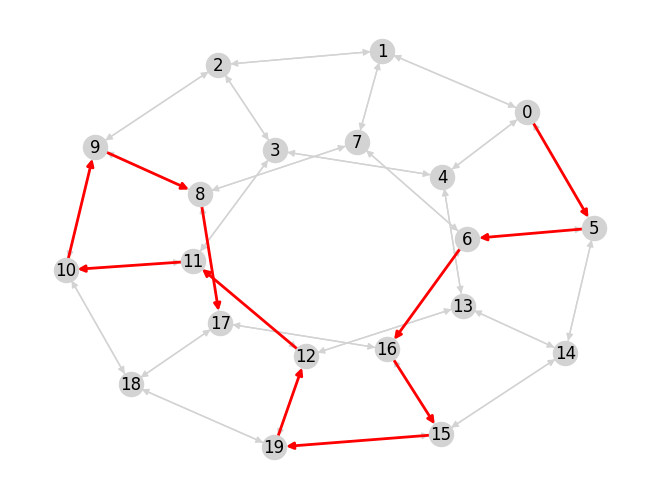

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
# Example model output (your data)
model_output = {
    'N_10': 9, 'N_0': 5, 'N_2': 22, 'N_4': 13, 'N_7': 1, 'N_17': 21, 'N_16': 15, 'N_6': 16, 'N_15': 19, 
    'N_8': 17, 'N_14': 23, 'N_19': 12, 'N_18': 20, 'N_11': 10, 'N_1': 7, 'N_9': 8, 'N_13': 4, 'N_5': 6, 'N_12': 11
}

# Assuming model_output['N_i'] gives the next node from node i
start_node = 0  # starting node
end_node = 17   # end node
path = [start_node]
current_node = start_node

while current_node != end_node:
    current_node = model_output.get(f'N_{current_node}', None)
    if current_node is None:
        print("Path not found or incomplete in model output.")
        break
    path.append(current_node)

# Now 'path' contains the sequence of nodes from start to end

# Plot the graph and highlight the path (assuming 'grdodec' is your graph)
G = nx.DiGraph()
G.add_nodes_from(grdodec)
for i in grdodec:
    for j in grdodec[i]:
        G.add_edge(i, j)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgrey', edge_color='lightgrey', arrows=True)

# Highlight the path
path_edges = [(path[n], path[n+1]) for n in range(len(path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2.0, arrows=True)

plt.show()


In [ ]:
    def check_conflict(self, current_queen, queen_row, model, is_final = False):
        queen_column = self.queen_to_col[current_queen]
        queen_column = int(queen_column.as_long())
        queen_row = int(queen_row.as_long())

        for fixed_queen in self._fixed_le:
            other_queen = fixed_queen[0]
            other_queen_column = self.queen_to_col[other_queen]
            other_queen_row = fixed_queen[1]

            other_queen_column = int(other_queen_column.as_long())
            other_queen_row = int(other_queen_row.as_long())

            diff_row = abs(other_queen_row - queen_row)
            diff_col = abs(other_queen_column - queen_column)
            
            if diff_col == diff_row:
                self.conflict(deps = [current_queen, other_queen])                
                return True
        return False